In [1]:
###  Import modules


import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



In [2]:
%%javascript
require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {}

<IPython.core.display.Javascript object>

In [3]:
###  User-Choices of Parameters


###  Choose  Reynolds number  Re
Re = 50
# Re = 62
# Re = 75
# Re = 87
# Re = 100


###  Choose which  coarse-grained data
# data_choice_string = 'U'
# data_choice_string = 'V'
data_choice_string = 'W'


###  Choose which  bounds of integration
y_CG_1 = -8 ; y_CG_2 = 8
# y_CG_1 = -1 ; y_CG_2 = 1


###  Choose time-delay embedding
TD_Embed = 2
# TD_Embed = 4
# TD_Embed = 6


###  Choose  x-domain
## x = [2, 9]      Sam Rudy subdomain
# x_trnc_pt_a = 199 ; x_trnc_pt_b = 549

## x = [2, 49.5]   Full domain
x_trnc_pt_a = 199 ; x_trnc_pt_b = 2574



In [4]:
### PDE-FIND Parameters


threshold = 0
# threshold = 0.025
# threshold = 0.003
# threshold = 0.0125


should_interact = False
# should_interact = True


should_normalize = True

is_periodic = False

deriv_order = 2


PolyPower = 23
# PolyPower = 2345


# False turns off CONSTANT term
should_bias = False
# should_bias = True

# Split between training/testing sets
train_proportion = 0.8


print('threshold        = ' + str(threshold))
print('should_interact  = ' + str(should_interact))
print('should_normalize = ' + str(should_normalize))
print('is_periodic      = ' + str(is_periodic))
print('derivative order = ' + str(deriv_order))
print('Polynomial order = ' + str(PolyPower))

print('\nBias (constant) term? Usually should be False!\nshould_bias = ' + str(should_bias)+'\n')

print('Training data proportion = ' + str(train_proportion)+'\n\n')



threshold        = 0
should_interact  = False
should_normalize = True
is_periodic      = False
derivative order = 2
Polynomial order = 23

Bias (constant) term? Usually should be False!
should_bias = True

Training data proportion = 0.8




In [5]:
###  fodder



In [6]:
###  Set the loading stem and load the data and parameters


stem = '/Users/josephwilliams/Documents/Data_Results/Coarse-Grained-Vortex-Shedding/Vortex Shedding Data/Coarse-Grained Data/'


data = np.load( stem + 'y-avg/Re' + str(Re) + '/' + data_choice_string + '/' + data_choice_string + '_y' + str(y_CG_1) + '_y' + str(y_CG_2) + '.npy' )


x  = np.load( stem + 'Parameters/Re' + str(Re) + '/x.npy' )
t  = np.load( stem + 'Parameters/Re' + str(Re) + '/t.npy' )
dx = np.load( stem + 'Parameters/Re' + str(Re) + '/dx.npy' )[0][0]
dt = np.load( stem + 'Parameters/Re' + str(Re) + '/dt.npy' )[0][0]



In [7]:
###  Pre-Process the data


# Normalize the data to min/max = +/- 1
data = data / np.max(np.max( np.abs(data) ))


# Time-Delay Embed
t_1 = t
t_2 = t+TD_Embed
TD_Embed_Index = np.argmin( np.abs(t - TD_Embed) )
TD_Embed_backendIndex = np.argmin( np.abs( t_2 - np.max(t_1) ) ) 

data_1 = data[: , TD_Embed_Index:-1 ]
data_2 = data[: , 0:TD_Embed_backendIndex ]
t_Ovlp = t[TD_Embed_Index:-1]
t_PF = t_Ovlp - t_Ovlp[0]


# Compute time-derivatives of the data
data_1_dt = ps.FiniteDifference(axis=1)._differentiate(data_1   , dt)
data_2_dt = ps.FiniteDifference(axis=1)._differentiate(data_2   , dt)



In [8]:
### Create the truncated space vector


x_PF = x[1+x_trnc_pt_a:1+x_trnc_pt_b+1]
n_X_PF = x_trnc_pt_b - x_trnc_pt_a + 1

print('n_X_PF = ' + str(n_X_PF) )
print('x_a = ' + str(x[1+x_trnc_pt_a]))
print('x_b = ' + str(x[1+x_trnc_pt_b]))



# Create the data and d/dt data matrices for PDE-FIND

u              = np.zeros( ( n_X_PF , len(t_PF), 2) )
u[:, :, 0]     = data_1[ x_trnc_pt_a:x_trnc_pt_b+1 , : ]
u[:, :, 1]     = data_2[ x_trnc_pt_a:x_trnc_pt_b+1 , : ]

u_dot          = np.zeros( ( n_X_PF , len(t_PF), 2) )
u_dot[:, :, 0] = data_1_dt[ x_trnc_pt_a:x_trnc_pt_b+1 , : ]
u_dot[:, :, 1] = data_2_dt[ x_trnc_pt_a:x_trnc_pt_b+1 , : ]





n_X_PF = 2376
x_a = 2.0000000000000036
x_b = 49.50000000000004


In [9]:
###  fodder



In [10]:
### Libraries

if PolyPower == 3:

    library_functions = [
        lambda x: x,
        lambda x: x * x * x,
        lambda x, y: x * y * y,
        lambda x, y: x * x * y,
    ]

    library_function_names = [
        lambda x: x,
        lambda x: x + x + x,
        lambda x, y: x + y + y,
        lambda x, y: x + x + y,
    ]


if PolyPower == 5:

    library_functions = [
        lambda x: x,
        lambda x: x * x * x,
        lambda x, y: x * y * y,
        lambda x, y: x * x * y,
        lambda x: x * x * x * x * x,
        lambda x, y: x * x * x * x * y,
        lambda x, y: x * x * x * y * y,
        lambda x, y: x * x * y * y * y,
        lambda x, y: x * y * y * y * y,
    ]

    library_function_names = [
        lambda x: x,
        lambda x: x + x + x,
        lambda x, y: x + y + y,
        lambda x, y: x + x + y,
        lambda x: x + x + x + x + x,
        lambda x, y: x + x + x + x + y,
        lambda x, y: x + x + x + y + y,
        lambda x, y: x + x + y + y + y,
        lambda x, y: x + y + y + y + y,
    ]


if PolyPower == 23:

    library_functions = [
        lambda x: x,
        lambda x: x * x,
        lambda x, y: x * y,
        lambda x: x * x * x,
        lambda x, y: x * x * y,
        lambda x, y: x * y * y,
    ]

    library_function_names = [
        lambda x: x,
        lambda x: x + x,
        lambda x, y: x + y,
        lambda x: x + x + x,
        lambda x, y: x + x + y,
        lambda x, y: x + y + y,
    ]

    
if PolyPower == 2345:

    library_functions = [
        lambda x: x,
        lambda x: x * x,
        lambda x, y: x * y,
        lambda x: x * x * x,
        lambda x, y: x * x * y,
        lambda x, y: x * y * y,
        lambda x: x * x * x * x,
        lambda x, y: x * x * x * y,
        lambda x, y: x * x * y * y,
        lambda x, y: x * y * x * y,
        lambda x: x * x * x * x * x,
        lambda x, y: x * x * x * x * y,
        lambda x, y: x * x * x * y * y,
        lambda x, y: x * x * y * y * y,
        lambda x, y: x * y * y * y * y,
    ]

    library_function_names = [
        lambda x: x,
        lambda x: x + x,
        lambda x, y: x + y,
        lambda x: x + x + x,
        lambda x, y: x + x + y,
        lambda x, y: x + y + y,
        lambda x: x + x + x + x,
        lambda x, y: x + x + x + y,
        lambda x, y: x + x + y + y,
        lambda x, y: x + y + y + y,
        lambda x: x + x + x + x + x,
        lambda x, y: x + x + x + x + y,
        lambda x, y: x + x + x + y + y,
        lambda x, y: x + x + y + y + y,
        lambda x, y: x + y + y + y + y,
    ]


In [11]:
###  Initialize and run PDE-FIND


train = np.random.choice(len(t_PF), int(len(t_PF) * train_proportion), replace=False)
test = [i for i in np.arange(len(t_PF)) if i not in train]
u_train = u[:, train, :]
u_test = u[:, test, :]
u_dot_train = u_dot[:, train, :]
u_dot_test = u_dot[:, test, :]
t_train = t_PF[train]
t_test = t_PF[test]


spatial_grid = np.asarray([x_PF]).T


###  Derivatives turned on and spatial grid included
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=deriv_order,
    spatial_grid=spatial_grid,
    include_bias=should_bias,
    include_interaction=should_interact,
    is_uniform=True,
    periodic=is_periodic
)


optimizer = ps.STLSQ(
    threshold=threshold, 
    alpha=1e-5, 
    normalize_columns=False, 
    max_iter=200
)


model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=["u", "v"])
model.fit(u_train, x_dot=u_dot_train )


u_dot_stlsq_train = model.predict(u_train)
u_dot_stlsq_test  = model.predict(u_test)
u_dot_stlsq_total = model.predict(u)



In [12]:
### Compute errors


u_dot_train_err = u_dot_train - u_dot_stlsq_train
u_dot_test_err  = u_dot_test  - u_dot_stlsq_test
u_dot_total_err = u_dot       - u_dot_stlsq_total

NRMSE_train = np.sqrt( np.sum( np.sum( u_dot_train_err**2 , axis=0 ) , axis=0) / np.sum( np.sum( u_dot_train**2 , axis=0 ) , axis=0) )
NRMSE_test  = np.sqrt( np.sum( np.sum( u_dot_test_err**2 , axis=0 ) , axis=0)  / np.sum( np.sum( u_dot_test**2  , axis=0 ) , axis=0) )
NRMSE_total = np.sqrt( np.sum( np.sum( u_dot_total_err**2 , axis=0 ) , axis=0) / np.sum( np.sum( u_dot**2       , axis=0 ) , axis=0) )

NRMSE_train_sys = np.sqrt( np.sum( NRMSE_train**2 ) )
NRMSE_test_sys  = np.sqrt( np.sum( NRMSE_test**2  ) )
NRMSE_total_sys = np.sqrt( np.sum( NRMSE_total**2 ) )




In [13]:
###  Compute  score


score_test = model.score(u_test, t=t_test)
# score_train = model.score(u_train, t=np.sort(t_train) )



In [14]:
###  Post-processing for writing these coefficients out later

Coefs_u1 = model.coefficients()[0 , :]
Coefs_u2 = model.coefficients()[1 , :]


In [15]:
###  Print all info regarding generated sparse model from PDE-FIND!!


print('\nx_a = ' + str(x[1+x_trnc_pt_a]))
print('x_b = ' + str(x[1+x_trnc_pt_b])+'\n')


print('Sparsity threshold = ' + str(threshold) + '\n')


print('Library terms:')
print(pde_lib.get_feature_names())
print('\n\n')


print('STLSQ model: ')
model.print(precision=10)
# model.print(precision=4)


print('\n\n***** Normalized Room Mean Square Errors (NRMSE)\n')
print('(u1, u2) Training Set NRMSE = ( ' + str(NRMSE_train[0]) + ' , '   + str(NRMSE_train[1]) + ' )' )
print('(u1, u2) Testing  Set NRMSE = ( ' + str(NRMSE_test[0])  + ' , '   + str(NRMSE_test[1])  + ' )' )
print('(u1, u2) Total    Set NRMSE = ( ' + str(NRMSE_total[0]) + ' , '   + str(NRMSE_total[1]) + ' )' + '\n' )

print('System Training NRMSE = ' + str(NRMSE_train_sys) )
print('System Testing  NRMSE = ' + str(NRMSE_test_sys)  )
print('System Total    NRMSE = ' + str(NRMSE_total_sys) )

print('\n\n')

print('Test Score is  =  ' + str(score_test) + '\n\n' )





x_a = 2.0000000000000036
x_b = 49.50000000000004

Sparsity threshold = 0

Library terms:
['1', 'x0', 'x1', 'x0x0', 'x1x1', 'x0x1', 'x0x0x0', 'x1x1x1', 'x0x0x1', 'x0x1x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11']



STLSQ model: 
(u)' = -0.0000253288 1 + -0.0022203642 u + -0.5525185562 v + 0.0000248739 uu + 0.0000298033 vv + -0.0000003471 uv + 0.0094977449 uuu + 0.0016189691 vvv + 0.0130072228 uuv + -0.0084434050 uvv + -0.4680596433 u_1 + 0.0158770379 v_1 + -0.0140631060 u_11 + -0.2224222975 v_11
(v)' = -0.0000243381 1 + 0.5496406866 u + 0.0066242520 v + 0.0000302008 uu + 0.0000268293 vv + -0.0000025889 uv + -0.0012177996 uuu + 0.0071475689 vvv + -0.0101469191 uuv + -0.0120898427 uvv + -0.0204340675 u_1 + -0.4716559790 v_1 + 0.2225215924 u_11 + -0.0138655726 v_11


***** Normalized Room Mean Square Errors (NRMSE)

(u1, u2) Training Set NRMSE = ( 0.008784661553530575 , 0.008595374500714185 )
(u1, u2) Testing  Set NRMSE = ( 0.008747638498979467 , 0.008629826350521475 )
(u1, u2) Total    Set NRM

In [16]:
###  fodder

###  jump here  for results (crtl-f 'jump')


In [17]:
###  Build the meshes for colorplots

xt_mshgrd, tx_mshgrd = np.meshgrid(x_PF , t_PF)


###  Set plotting points in space (x) and time (t)

tplt = 0
xplt = -1



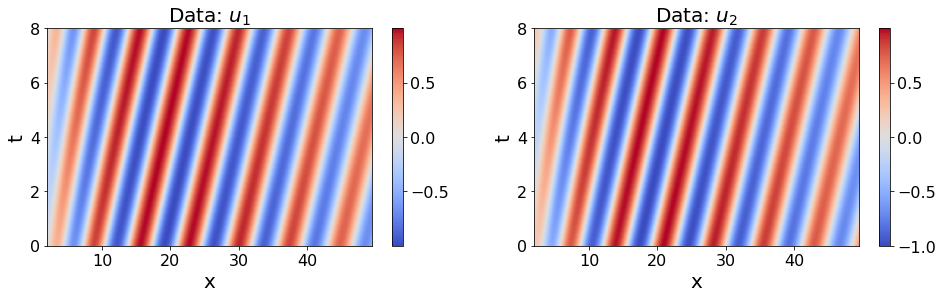

In [18]:
### Colorplots of the  data

plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u[:,:,0].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Data: $u_1$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)


plt.subplot(1, 2, 2)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u[:,:,1].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Data: $u_2$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



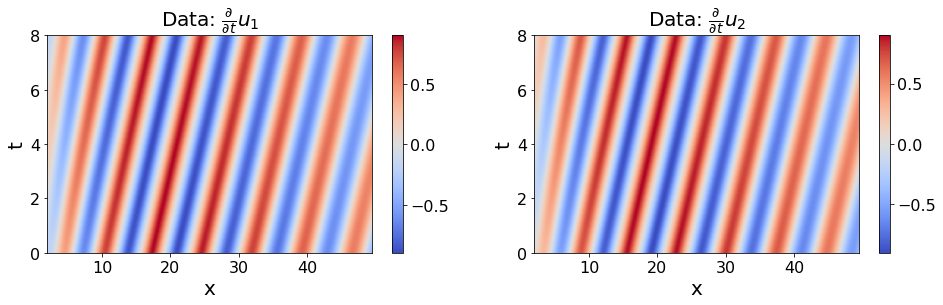

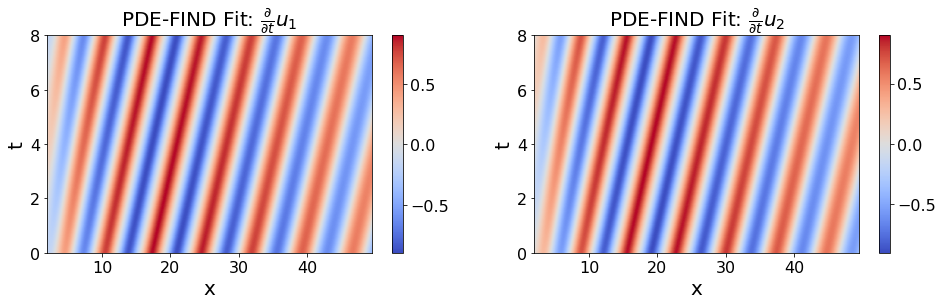

In [19]:
### Colorplots of the  (d/dt  data)

plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot[:,:,0].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Data: $\frac{\partial }{\partial t} u_1$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)


plt.subplot(1, 2, 2)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot[:,:,1].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Data: $\frac{\partial }{\partial t} u_2$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



### Colorplots of PDE-FIND fit

plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_stlsq_total[:,:,0].T, cmap='coolwarm', vmin=np.min(np.min(u_dot[:,:,0]) ), vmax=np.max(np.max(u_dot[:,:,0]) ) )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'PDE-FIND Fit: $\frac{\partial }{\partial t} u_1$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)


plt.subplot(1, 2, 2)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_stlsq_total[:,:,1].T, cmap='coolwarm', vmin=np.min(np.min(u_dot[:,:,1]) ), vmax=np.max(np.max(u_dot[:,:,1]) ) )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'PDE-FIND Fit: $\frac{\partial }{\partial t} u_2$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



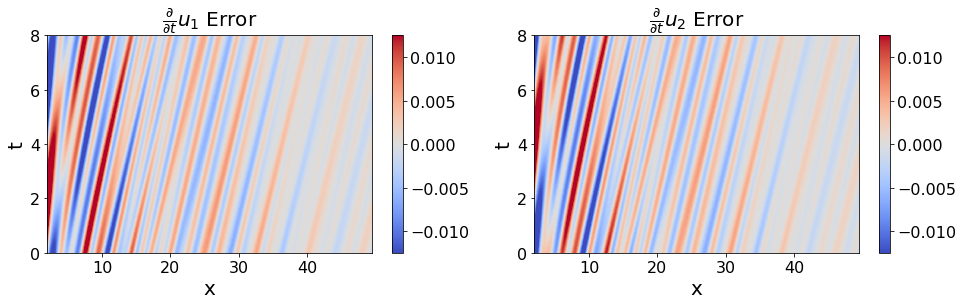

In [28]:
### Colorplots of the error


vminmax = 0.0125


## Plots

plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_total_err[:,:,0].T, cmap='coolwarm' , vmin = -vminmax , vmax = vminmax )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'$\frac{\partial }{\partial t} u_1$ Error', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)


plt.subplot(1, 2, 2)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_total_err[:,:,1].T, cmap='coolwarm' , vmin = -vminmax , vmax = vminmax )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'$\frac{\partial }{\partial t} u_2$ Error', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



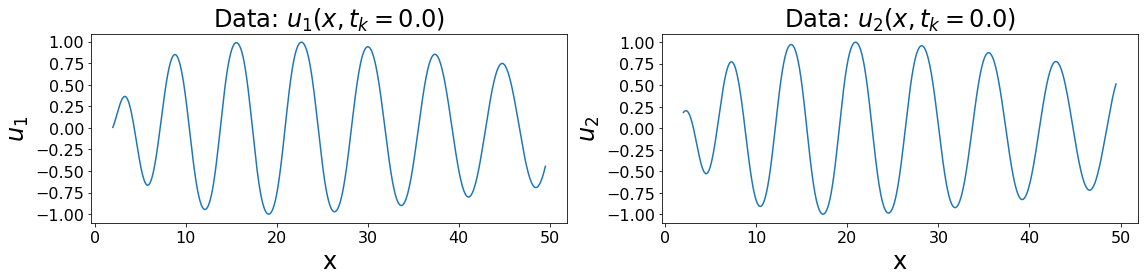

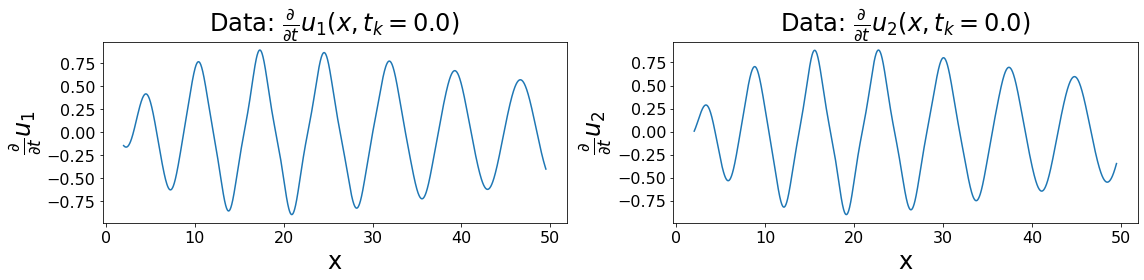

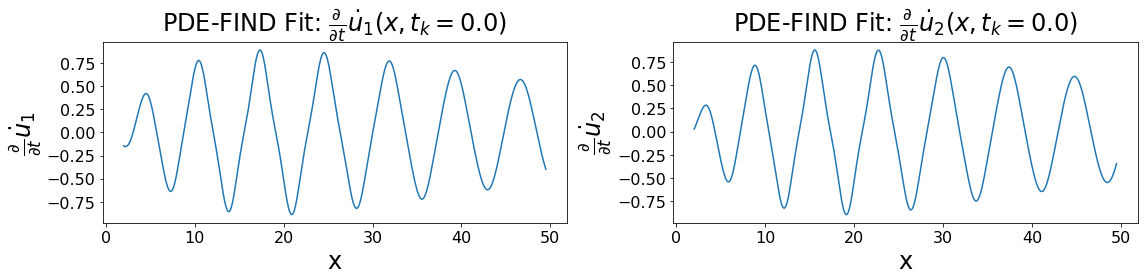

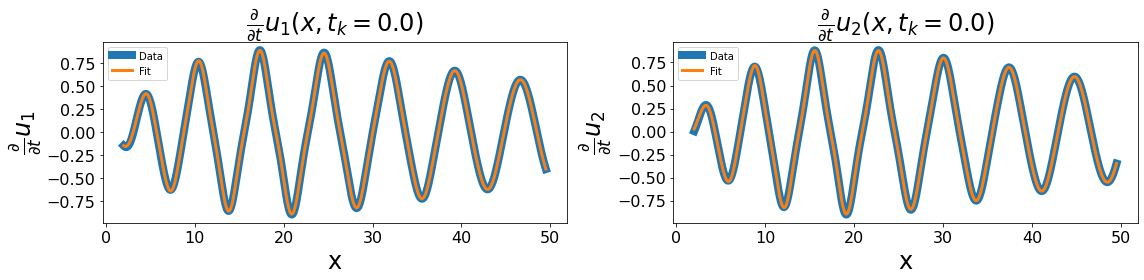

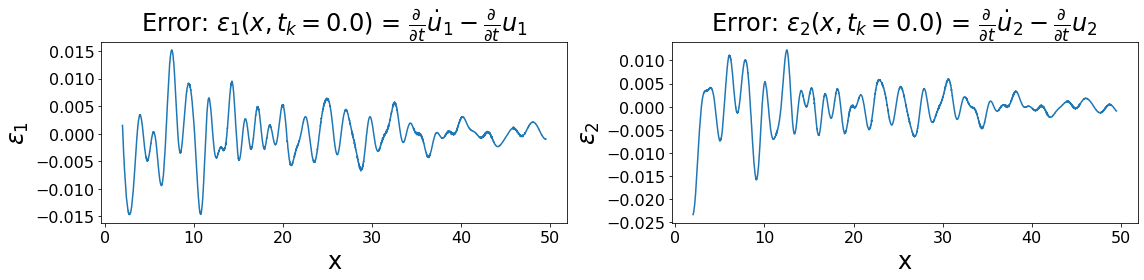

In [21]:
###  Line plots of  slices of time  at  t = t_k




###


plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( x_PF , u[:,tplt,0])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$u_1$', fontsize=24)
ttl_str = r'Data: $u_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u[:,tplt,1])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$u_2$', fontsize=24)
ttl_str = r'Data: $u_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()






plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( x_PF , u_dot[:,tplt,0])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'Data: $\frac{\partial}{\partial t}u_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u_dot[:,tplt,1])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'Data: $\frac{\partial}{\partial t}u_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()






plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,0])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}\dot{u}_1$', fontsize=24)
ttl_str = r'PDE-FIND Fit: $\frac{\partial}{\partial t}\dot{u}_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,1])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}\dot{u}_2$', fontsize=24)
ttl_str = r'PDE-FIND Fit: $\frac{\partial}{\partial t}\dot{u}_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



plt.tight_layout()
plt.show()



plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)

plt.plot( x_PF , u_dot[:,tplt,0] , label='Data' , linewidth = 8)
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,0] , label='Fit' , linewidth = 3)


plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'$\frac{\partial}{\partial t}u_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()


plt.subplot(1, 2, 2)

plt.plot( x_PF , u_dot[:,tplt,1] , label='Data' , linewidth = 8)
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,1] , label='Fit' , linewidth = 3)


plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'$\frac{\partial}{\partial t}u_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()


plt.tight_layout()
plt.show()





plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( x_PF , u_dot_total_err[:,tplt,0])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\epsilon_1$', fontsize=24)
ttl_str = r'Error: $\epsilon_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + r') = $\frac{\partial}{\partial t}\dot{u}_1 - \frac{\partial}{\partial t}u_1$'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u_dot_total_err[:,tplt,1])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\epsilon_2$', fontsize=24)
ttl_str = r'Error: $\epsilon_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + r') = $\frac{\partial}{\partial t}\dot{u}_2 - \frac{\partial}{\partial t}u_2$'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.show()




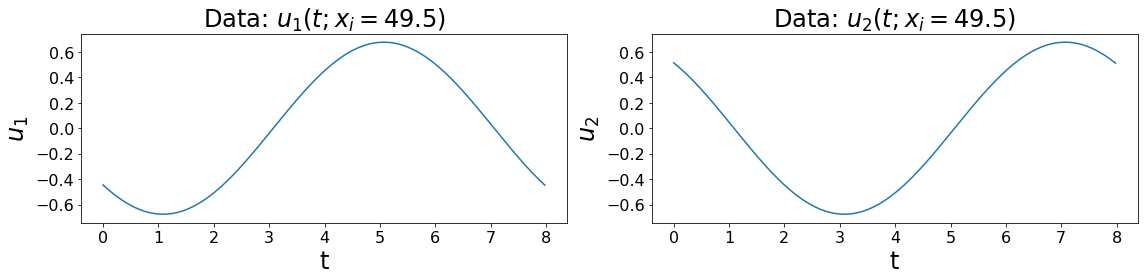

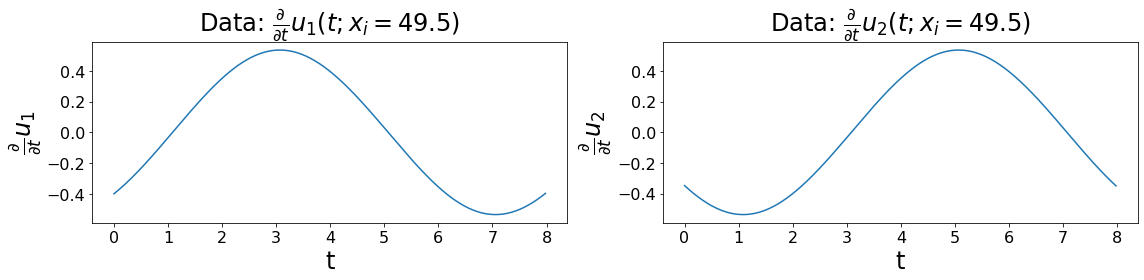

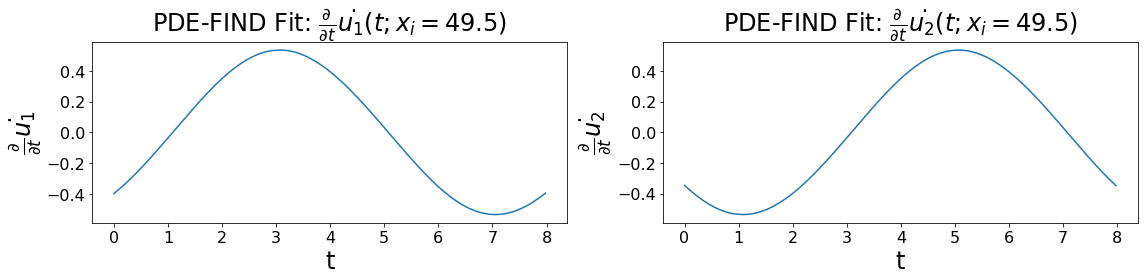

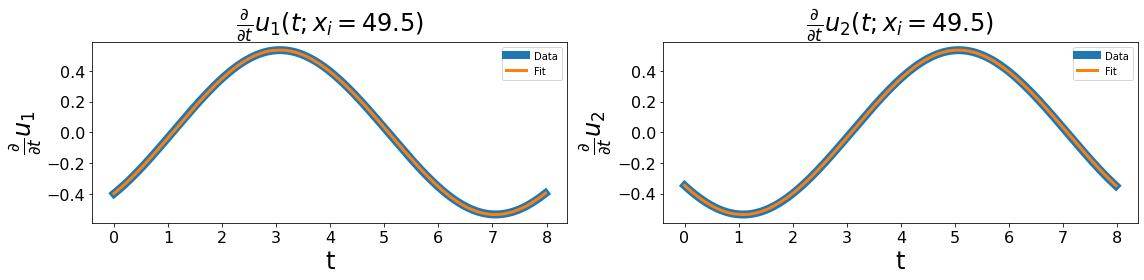

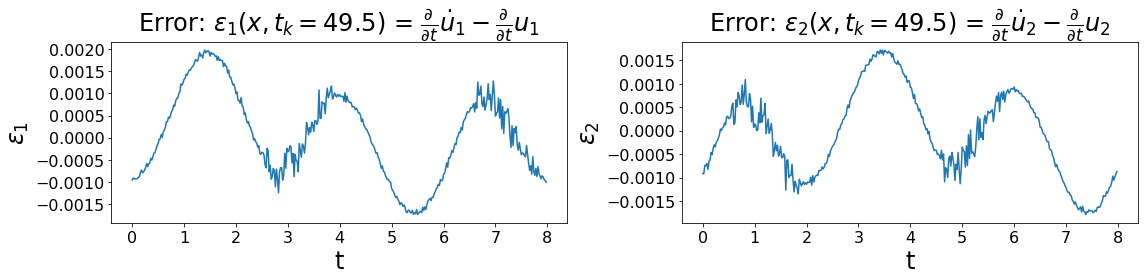

In [22]:
###  Line plots of  slices of space  at  x = x_i




###  


plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( t_PF , u[xplt,:,0])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$u_1$', fontsize=24)
ttl_str = r'Data: $u_1 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u[xplt,:,1])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$u_2$', fontsize=24)
ttl_str = r'Data: $u_2 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()




plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( t_PF , u_dot[xplt,:,0])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)

ttl_str = r'Data: $\frac{\partial}{\partial t}u_1 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u_dot[xplt,:,1])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)

ttl_str = r'Data: $\frac{\partial}{\partial t}u_2 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()





plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,0])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}\dot{u_1}$', fontsize=24)

ttl_str = r'PDE-FIND Fit: $\frac{\partial}{\partial t}\dot{u_1} (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,1])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}\dot{u_2}$', fontsize=24)

ttl_str = r'PDE-FIND Fit: $\frac{\partial}{\partial t}\dot{u_2} (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



plt.tight_layout()
plt.show()




plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)

plt.plot( t_PF , u_dot[xplt,:,0] , label='Data' , linewidth = 8)
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,0] , label='Fit' , linewidth = 3)


plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'$\frac{\partial}{\partial t}u_1 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()



plt.subplot(1, 2, 2)

plt.plot( t_PF , u_dot[xplt,:,1] , label='Data' , linewidth = 8)
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,1] , label='Fit' , linewidth = 3)


plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'$\frac{\partial}{\partial t}u_2 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()



plt.tight_layout()
plt.show()










plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( t_PF , u_dot_total_err[xplt,:,0])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\epsilon_1$', fontsize=24)
ttl_str = r'Error: $\epsilon_1 (x, t_k = $' + str( np.round(x_PF[xplt],2) )  + r') = $\frac{\partial}{\partial t}\dot{u}_1 - \frac{\partial}{\partial t}u_1$'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u_dot_total_err[xplt,:,1])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\epsilon_2$', fontsize=24)
ttl_str = r'Error: $\epsilon_2 (x, t_k = $' + str( np.round(x_PF[xplt],2) )  + r') = $\frac{\partial}{\partial t}\dot{u}_2 - \frac{\partial}{\partial t}u_2$'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.show()






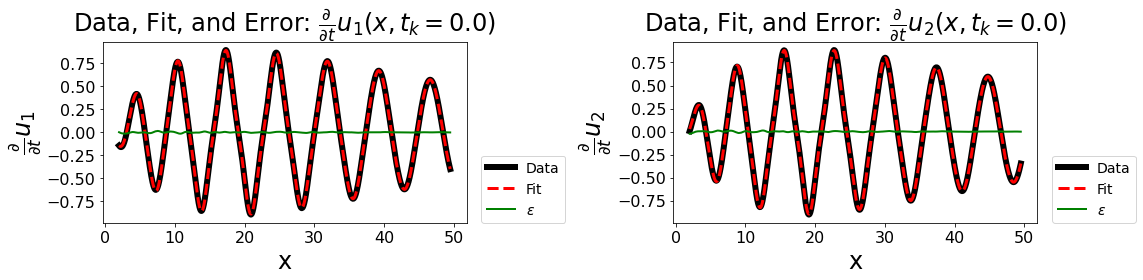

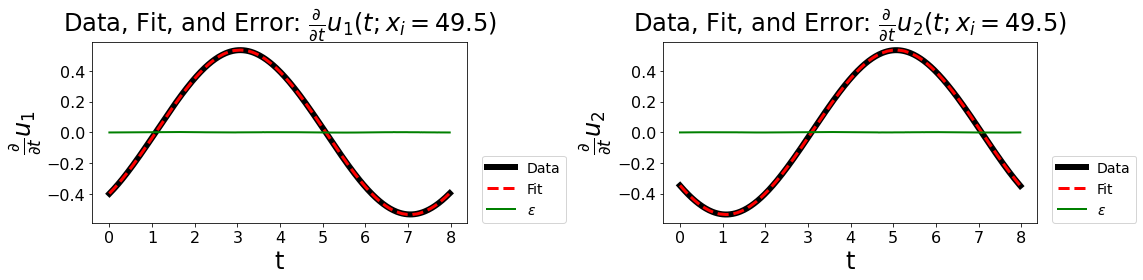

In [23]:
### Plot slices and errors together


plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.plot( x_PF , u_dot[:,tplt,0]           , 'k-'  , linewidth = 6 , label='Data' , )
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,0] , 'r--' , linewidth = 3 , label='Fit')
plt.plot( x_PF , u_dot_total_err[:,tplt,0]   , 'g-' ,  linewidth = 2 , label='$\epsilon$')

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'Data, Fit, and Error: $\frac{\partial}{\partial t}u_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks([-0.75,-0.5,-0.25,0,0.25,0.5,0.75],fontsize=16)
plt.legend( loc=(1.04, 0) , fontsize=14)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u_dot[:,tplt,1]           , 'k-'  , linewidth = 6 , label='Data' , )
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,1] , 'r--' , linewidth = 3 , label='Fit')
plt.plot( x_PF , u_dot_total_err[:,tplt,1]   , 'g-' ,  linewidth = 2 , label='$\epsilon$')

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'Data, Fit, and Error: $\frac{\partial}{\partial t}u_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend( loc=(1.04, 0) , fontsize=14)


plt.tight_layout()
plt.show()





plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.plot( t_PF , u_dot[xplt,:,0]           , 'k-'  , linewidth = 6 , label='Data' , )
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,0] , 'r--' , linewidth = 3 , label='Fit')
plt.plot( t_PF , u_dot_total_err[xplt,:,0]   , 'g-' ,  linewidth = 2 , label='$\epsilon$')

plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'Data, Fit, and Error: $\frac{\partial}{\partial t}u_1 (t; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend( loc=(1.04, 0) , fontsize=14)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u_dot[xplt,:,1]           , 'k-'  , linewidth = 6 , label='Data' , )
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,1] , 'r--' , linewidth = 3 , label='Fit')
plt.plot( t_PF , u_dot_total_err[xplt,:,1]   , 'g-' ,  linewidth = 2 , label='$\epsilon$')

plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'Data, Fit, and Error: $\frac{\partial}{\partial t}u_2 (t; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend( loc=(1.04, 0) , fontsize=14)


plt.tight_layout()
plt.show()




In [24]:
###  fodder



In [25]:
###########################################################################
# This code is slightly adjusted from Zachary G. Nicolaou's code for computing the normal form parameters
# See: https://github.com/dynamicslab/pysindy/blob/master/examples/17_parameterized_pattern_formation/utils.py
# Specifically, on line 1280 of that code: def get_normal_form_parameters(model, us, printcoefs=False): 

# The changes are specifically to the computation of:  b ,  c ,  alpha 
###########################################################################


###  Compute the  Hopf bifurcation  normal form parameters  (beta, sigma)


lib = model.feature_library
opt = model.optimizer


bs = np.linspace(0, 1, 1)


# D = np.zeros((len(bs), 2, 2))
# D[:, :, 0] = opt.coef_[:, 11].T
# D[:, :, 1] = opt.coef_[:, 12].T


A = np.zeros((len(bs), 2, 2))
A[:, :, 0] = [1, 0] # - opt.coef_[:, Xts].T
A[:, :, 1] = [0, 1] # - opt.coef_[:, Yts].T



J = np.zeros((len(bs), 2, 2))
Fxx = np.zeros((len(bs), 2, 2, 2))
Fxxx = np.zeros((len(bs), 2, 2, 2, 2))


J[:, :, 0] = opt.coef_[:, 0].T
J[:, :, 1] = opt.coef_[:, 1].T
Fxx[:, :, 0, 0] = opt.coef_[:, 2].T * 2
Fxx[:, :, 0, 1] = opt.coef_[:, 4].T
Fxx[:, :, 1, 0] = opt.coef_[:, 4].T
Fxx[:, :, 1, 1] = opt.coef_[:, 3].T * 2
Fxxx[:, :, 0, 0, 0] = opt.coef_[:, 5].T * 6
Fxxx[:, :, 0, 0, 1] = opt.coef_[:, 7].T * 2
Fxxx[:, :, 0, 1, 0] = opt.coef_[:, 7].T * 2
Fxxx[:, :, 1, 0, 0] = opt.coef_[:, 7].T * 2
Fxxx[:, :, 0, 1, 1] = opt.coef_[:, 8].T * 2
Fxxx[:, :, 1, 0, 1] = opt.coef_[:, 8].T * 2
Fxxx[:, :, 1, 1, 0] = opt.coef_[:, 8].T * 2
Fxxx[:, :, 1, 1, 1] = opt.coef_[:, 6].T * 6

lambdas, Us = np.linalg.eig(np.einsum("aij,ajk->aik", np.linalg.inv(A), J))

u_rename = Us[:, :, 0]
ubar_rename = np.conjugate(u_rename)
ut_rename = np.linalg.inv(Us)[:, 0, :]

a = np.einsum(
    "ni,nip,npjk,nj,nkl,nlmo,nm,no->n",
    ut_rename,
    np.linalg.inv(A),
    Fxx,
    u_rename,
    np.linalg.inv(J),
    Fxx,
    u_rename,
    ubar_rename,
)

b = (
    np.einsum(
        "ni,nip,npjk,nj,nkl,nlmo,nm,no->n",
        ut_rename,
        np.linalg.inv(A),
        Fxx,
        ubar_rename,
        np.linalg.inv(
            -J
            + (
                2*(lambdas[:, 0] - lambdas[:, 1])[:, np.newaxis, np.newaxis]
                * np.eye(2)[np.newaxis, :, :]
            )
        ),
        Fxx,
        u_rename,
        u_rename,
    )
    / 1
)

c = (
    np.einsum("ni,nip,npjkl,nj,nk,nl->n", ut_rename, np.linalg.inv(A), Fxxx, u_rename, u_rename, ubar_rename)
    / 1
)



###  Compute  alpha
#  This is the way to determine the parameters from Kuznetsov

alphas = c - 2*a + b
ANS_a_2 = np.real(alphas)

# alphas = a + b - c
# ANS_a, ANS_b = -np.imag(alphas) / np.real(alphas), np.imag(betas) / np.real(betas)

print('\nValue of ANS_a  =  ' + str(ANS_a_2)+'\n\n')



# betas = np.einsum("ni,nij,njk,nk->n", ut_rename, np.linalg.inv(A), D, u_rename)

Beta_hopf_1 = opt.coef_.T[0,0] / ( -1* opt.coef_.T[1,0] )
Beta_hopf_2 = opt.coef_.T[1,1] / opt.coef_.T[0,1]
Beta_hopf_avg = np.mean([Beta_hopf_1,Beta_hopf_2])

print('( 1st , 2nd )  Value of Beta  =  ( ' + str(Beta_hopf_1) + ' , ' + str(Beta_hopf_2) + ' )')
print('\nAvg Value of Beta  =  ' + str(Beta_hopf_avg ) )

print('\n\n')





Value of ANS_a  =  [96037.29711371]


( 1st , 2nd )  Value of Beta  =  ( -0.01140748445390204 , -22583.523077750175 )

Avg Value of Beta  =  -11291.767242617314





In [26]:
###  fodder



In [27]:
###  data dump:  Write out file with all parameters, computables ... 


datetime.date.today().strftime("%B %d, %Y")
datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

str_datetime = datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")
# save_path = '../x_'+str(np.round(x[1+x_trnc_pt_a],1))+'_'+str(np.round(x[1+x_trnc_pt_b],1))
save_path = '../Re' + str(Re) + '_' + data_choice_string+ '_y' + str(y_CG_1) + '_y' + str(y_CG_2) +'_x' + str(np.round(x[1+x_trnc_pt_a],1)) + '_x' + str(np.round(x[1+x_trnc_pt_b],1)) + '_TD' + str(TD_Embed)
os.mkdir(save_path)


# save_path
# save_path +'/readme.txt', 'w'

with open(save_path +'/readme.txt', 'w') as f:
#     f.write( Video_Load_String )
    
#     f.write( '\n\n\n  Number of frames =  ' + str(video_length) )
#     f.write( '\n  FPS =  ' + str(fps) )
#     f.write( '\n  Precise length =  ' + str(precise_time_length) + ' sec\n\n' )

#     f.write( '\n  Frame increment (subsampling) =  ' + str(frame_increment) )
    
    
    f.write( '\nRe                    =   ' + str(Re) + '\n')
    f.write( '\nData                  =   ' + data_choice_string + '\n')
    f.write( '\nTime-Delay Embedding  =   ' + str(TD_Embed) + '\n\n')
    
    f.write( '\nCoarse-Graining Interval: ' + str(y_CG_1) + ' <=  y  <=  ' + str(y_CG_2) + '\n\n')


    f.write( '\nx_a = ' + str(x[1+x_trnc_pt_a]) )
    f.write( '\nx_b = ' + str(x[1+x_trnc_pt_b])+'\n' )
    f.write( '\n\n' )
    
    f.write( '\nSparsity threshold   =   ' + str(threshold)        + '\n' )
    f.write( '\nTraining proportion  =   ' + str(train_proportion) + '\n'  )

    
    f.write( '\n\nLibrary terms:' )
    f.write( '\n' + str( pde_lib.get_feature_names() ) )
    f.write( '\n\n' )

    
    f.write( '\n\nSTLSQ model: ' )
    f.write( '\n\n' + str(Coefs_u1) )
    f.write( '\n\n' + str(Coefs_u2) + '\n\n\n')
    
    
    f.write('\n\n***** Normalized Room Mean Square Errors (NRMSE)\n\n\n')
    f.write('(u1, u2) Training Set NRMSE = ( ' + str(NRMSE_train[0]) + ' , '   + str(NRMSE_train[1]) + ' )'  + '\n' )
    f.write('(u1, u2) Testing  Set NRMSE = ( ' + str(NRMSE_test[0])  + ' , '   + str(NRMSE_test[1])  + ' )'  + '\n' )
    f.write('(u1, u2) Total    Set NRMSE = ( ' + str(NRMSE_total[0]) + ' , '   + str(NRMSE_total[1]) + ' )' + '\n\n\n' )

    f.write('System Training NRMSE = ' + str(NRMSE_train_sys)  + '\n' )
    f.write('System Testing  NRMSE = ' + str(NRMSE_test_sys)   + '\n' )
    f.write('System Total    NRMSE = ' + str(NRMSE_total_sys)  + '\n\n\n' )


    f.write('Test Score is  =  ' + str(score_test) + '\n\n' )


    
    
    f.write( '\n\n\n\n' )
    
    

    f.write( 'First Lyapunov coefficient l_1(0)     =  ' + str( ANS_a_2[0] )  )
    
    f.write( '\n\n' )
    
    
    
    f.write( 'Value of beta for normal form         =  ' + str( Beta_hopf_avg )  )
    
    
    f.write( '\n\n' )

# Anything else?

print('\n**************')
print('\n  Finished!!  ')
print('\n**************')




**************

  Finished!!  

**************
